# Classifying drawings of animals

In this project we use the [Quick!, Draw dataset](https://quickdraw.withgoogle.com/data) to train a model that can  classify doodles of animals. Specifically, I use a CNN and take a subsample of all animal classes available in the data, consisting of drawings of bears, elephants, lions, monkeys and crocodiles.

We start by showing how to download the data through an API call. We then prepare the data such that we can use it as input for a CNN model, where we use [Keras](https://keras.io). Next we compare a few different model configurations. We finish off by converting our model to javascript code using [tensorflow.js](https://www.tensorflow.org/js), such that we can use it on github pages.

## 1. Imports

We use the following libraries. You can use the requirements.txt file included in the repo to set up your environment.

In [67]:
# Imports
import urllib
import os
import glob
import numpy as np
from matplotlib import pyplot as plt

## 2. Data retrieval and preparation
In this section we pull the data through an API call and prepare our data.

The [Quick!, Draw dataset](https://quickdraw.withgoogle.com/data) is a collection of 50 million drawings across 350 categories, made by players of the game [Quick!, Draw](https://quickdraw.withgoogle.com). It's an awesome alternative to the often-used [MNIST database](https://en.wikipedia.org/wiki/MNIST_database) for those that want to experiment with ML in computer vision.

Since the full dataset is huge, we restrict our classification problem to 5 animal classes. We'll attempt to classify drawings of bears, elephants, lions, monkeys and crocodiles.

In [ ]:
# Select 5 animals
animals = ['bear', 'crocodile', 'elephant', 'lion', 'monkey']

# Download data for these animals
base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
for a in animals:
    path = base + a + '.npy'
    urllib.request.urlretrieve(path, 'data/' + a + '.npy')

# Printing dimensions and memory consumed by data
files = glob.glob(os.path.join('data', '*.npy'))
for f in files:
    print(f'{f} - dimensions: {np.load(f).shape}, memory: {round(np.load(f).nbytes * 10**-6)} Mb')

Fitting on this many samples will take quite a while. That's why we take 1000 samples for each animal class. We'll also split the data according to a 90/10 train/test split so that we can see how our model(s) perform on unseen data.

In [48]:
def prep_data(files, obs_per_class = 1000, test_size = 0.1):

    # Initialize x and y array
    x = np.empty((0, 784))
    y = np.empty((0))
    classes = []

    # Load array from dictionary
    for index, file_name in enumerate(files):
        data_array = np.load(file_name)
        np.random.shuffle(data_array)
        data_array = data_array[:obs_per_class, :]
        label = np.full(obs_per_class, index)
        class_ = os.path.splitext(os.path.basename(file_name))[0]

        x = np.vstack((x, data_array))
        y = np.append(y, label)
        classes.append(class_)
    
    # Randomize
    permutation = np.random.permutation(x.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    # Make train and test set
    size = int(x.shape[0] * test_size)
    x_test = x[:size, :]
    x_train = x[size:, :]
    y_test = y[:size]
    y_train = y[size:]

    return x_train, y_train, x_test, y_test, classes

x_train, y_train, x_test, y_test, classes = prep_data(files)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, len(classes), sep = ', ')

Let's take a look at some drawings in our sample dataset.

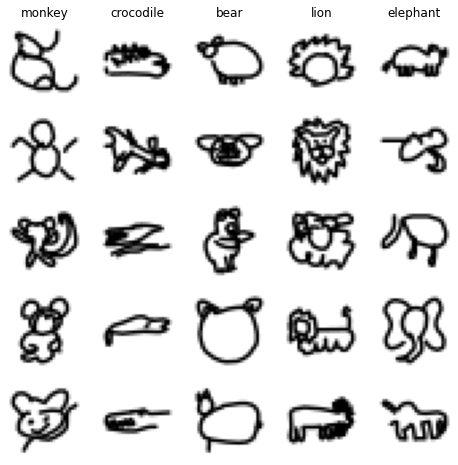

In [95]:
# We want to visualize some drawings
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(8, 8))

for label, ax, i in zip(np.tile(np.unique(y_train), 5), axs.flatten(), range(25)):
    if i < 5:
        ax.set_title(classes[int(label)])

    pixels = np.random.permutation(x_train[y_train == label, :])[0]
    pixels = pixels.reshape(28, 28)
    pixels = 255-pixels
    ax.imshow(pixels, cmap=plt.get_cmap('gray'))
    ax.axis('off')

## 3.1 Training models